In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import sys
sys.path.append('../')
import numpy as np
import cv2
import matplotlib.pyplot as plt
from utils import get_camvid_paths, get_bdd_paths, get_cityscapes_paths
from utils import visualize
from dataset import CamVid, BDD100K, Cityscapes

In [4]:
DATASET = Cityscapes # BDD100K, Cityscapes or CamVid

# Load data
if DATASET == CamVid:
    X_train_paths, y_train_paths, X_valid_paths, y_valid_paths = get_camvid_paths(DATA_DIR='./data/CamVid/')
elif DATASET == BDD100K:
    X_train_paths, y_train_paths, X_valid_paths, y_valid_paths = get_bdd_paths(DATA_DIR='/home/ruslan/datasets/bdd100k/seg/')
elif DATASET == Cityscapes:
    X_train_paths, y_train_paths, X_valid_paths, y_valid_paths = get_cityscapes_paths(DATA_DIR='/home/ruslan/datasets/Cityscapes/')
else:
    print('Choose DATASET_TYPE="CamVid" or "BDD100K"')

Found 2975 images in the folder /home/ruslan/datasets/Cityscapes/leftImg8bit/train
Found 500 images in the folder /home/ruslan/datasets/Cityscapes/leftImg8bit/val


### Dataloader

Writing helper class for data extraction, tranformation and preprocessing  
https://pytorch.org/docs/stable/data

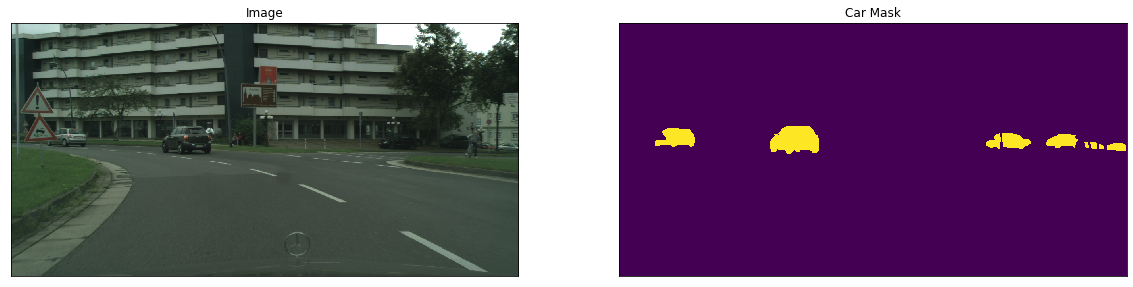

In [9]:
# Lets look at data we have

dataset = DATASET(X_train_paths, y_train_paths, classes=['car', 'road'])

image, mask = dataset[0] # get some sample

plt.figure(figsize=(20,10))
visualize(
    image=image, 
    car_mask=mask.squeeze()[...,0],
)

### Augmentations

In [10]:
from augmentations import get_training_augmentation, get_validation_augmentation, get_preprocessing

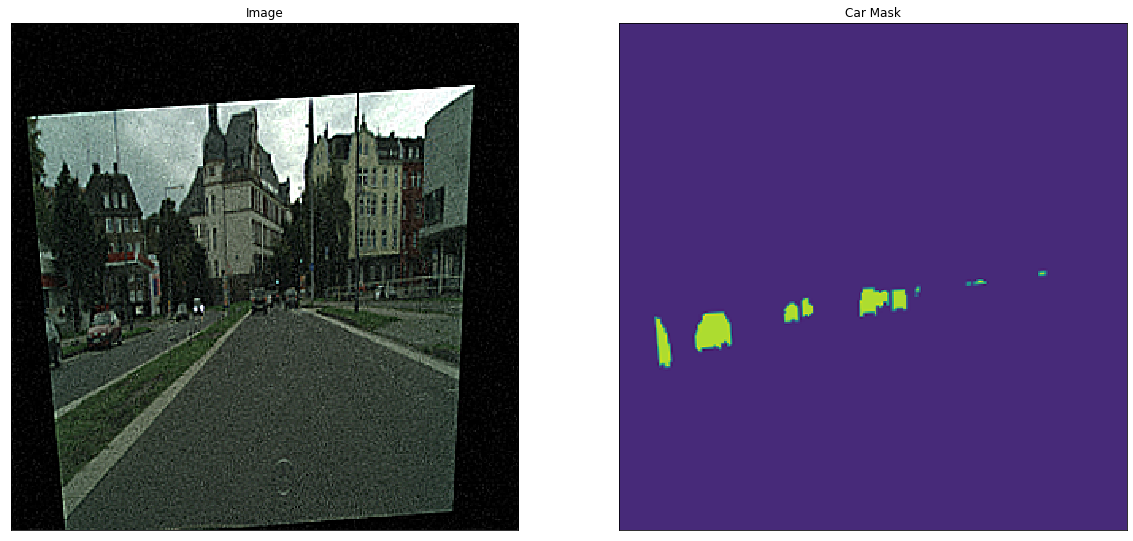

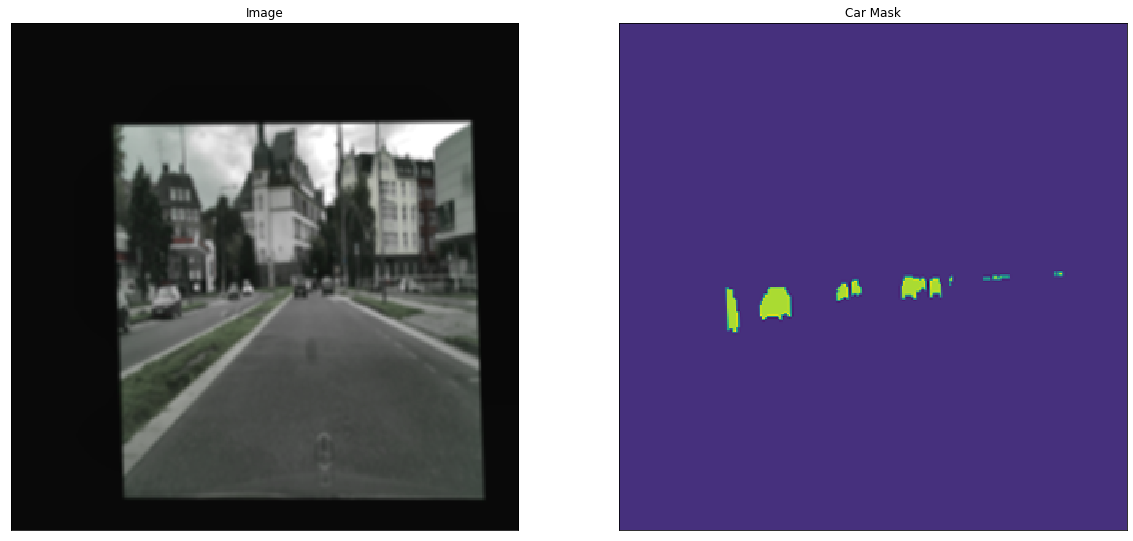

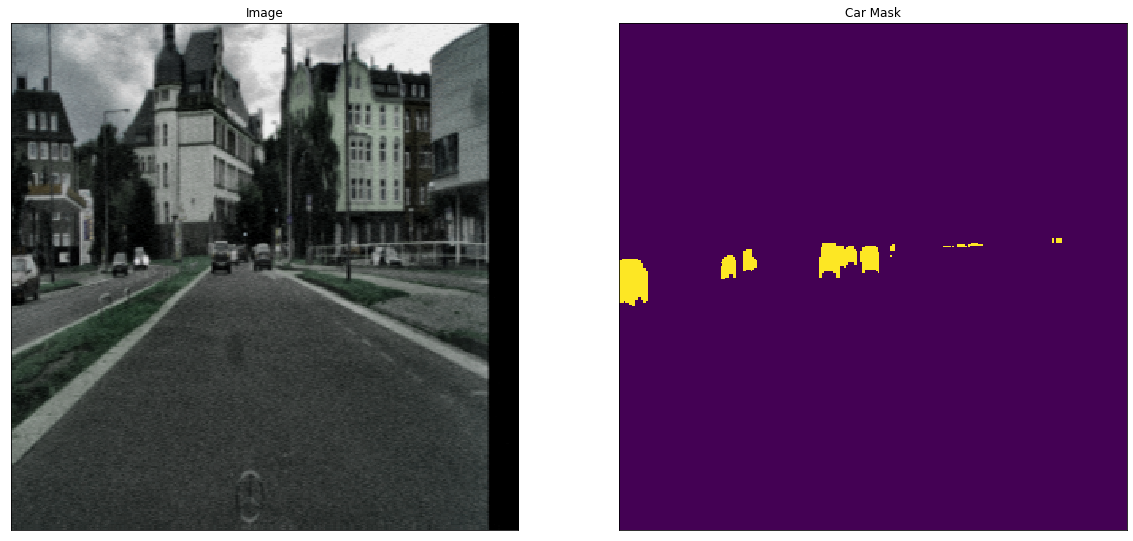

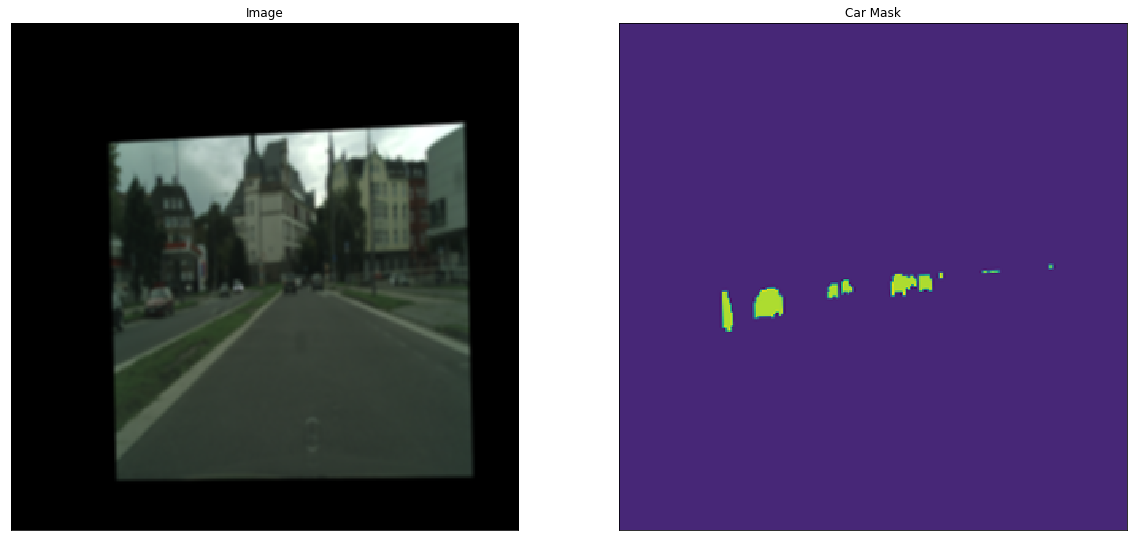

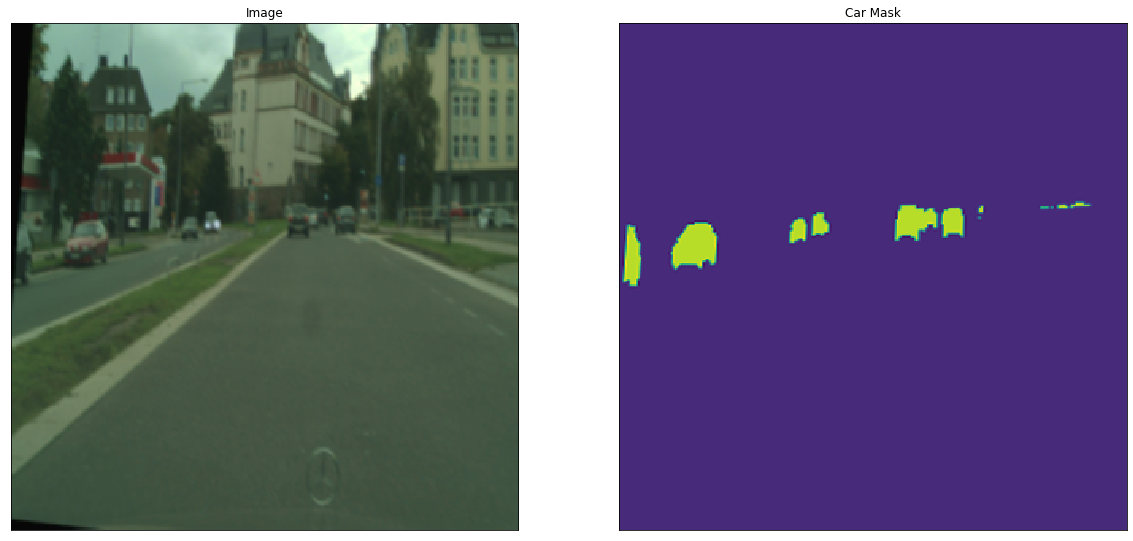

In [12]:
#### Visualize resulted augmented images and masks

augmented_dataset = DATASET(
    X_train_paths, 
    y_train_paths, 
    augmentation=get_training_augmentation(), 
    classes=['car', 'road'],
)

# same image with different random transforms
for i in range(5):
    image, mask = augmented_dataset[1]
    plt.figure(figsize=(20,10))
    visualize(image=image, car_mask=mask[...,0])

### Create model and train

In [13]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

ENCODER = 'mobilenet_v2'
ENCODER_WEIGHTS = 'imagenet'
# CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
#            'tree', 'signsymbol', 'fence', 'car', 
#            'pedestrian', 'bicyclist', 'unlabelled']
CLASSES = ['road', 'car']

n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
ACTIVATION = 'softmax2d' # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cuda'
LEARNING_RATE = 1e-4
EPOCHS = 5
BATCH_SIZE = 16

# create segmentation model with pretrained encoder
# model = smp.DeepLabV3(
#     encoder_name=ENCODER, 
#     encoder_weights=ENCODER_WEIGHTS, 
#     classes=n_classes, 
#     activation=ACTIVATION,
# )

model = smp.Unet(encoder_name=ENCODER,
                 encoder_weights=ENCODER_WEIGHTS,
                 classes=n_classes,
                 activation=ACTIVATION)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [14]:
from torch.utils.data import DataLoader

train_dataset = DATASET(
    X_train_paths, 
    y_train_paths, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = DATASET(
    X_valid_paths, 
    y_valid_paths, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

In [15]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
    smp.utils.metrics.Fscore(),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=LEARNING_RATE),
])

In [16]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [17]:
# train model

max_score = 0

for i in range(0, EPOCHS):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './unet_best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 500/500 [00:20<00:00, 24.84it/s, dice_loss - 0.104, iou_score - 0.8627, fscore - 0.9237]  
Model saved!

Epoch: 1
valid: 100%|██████████| 500/500 [00:20<00:00, 24.17it/s, dice_loss - 0.06888, iou_score - 0.8937, fscore - 0.942] 
Model saved!

Epoch: 2
valid: 100%|██████████| 500/500 [00:20<00:00, 24.27it/s, dice_loss - 0.06089, iou_score - 0.9013, fscore - 0.9454]
Model saved!

Epoch: 3
valid: 100%|██████████| 500/500 [00:20<00:00, 24.59it/s, dice_loss - 0.05762, iou_score - 0.9028, fscore - 0.9463]
Model saved!

Epoch: 4
valid: 100%|██████████| 500/500 [00:20<00:00, 24.46it/s, dice_loss - 0.0524, iou_score - 0.9098, fscore - 0.9505] 
Model saved!


### Anomaly detection

In [18]:
# load best saved checkpoint
best_model = torch.load('./unet_best_model.pth')

In [19]:
# create test dataset
test_dataset = DATASET(
    X_valid_paths, 
    y_valid_paths, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

In [20]:
# test dataset without transformations for image visualization
test_dataset_vis = DATASET(
    X_valid_paths, 
    y_valid_paths, 
    classes=CLASSES,
)

In [21]:
def entropy(mask_np):
    # mask_np.shape = (3, N, M)
    e = np.mean( (-mask_np * np.log2(mask_np)).sum(axis=0) )
    return e

In [22]:
def margin(mask_np):
    rev_probas = np.sort(mask_np, axis=0)[::-1, ...]
    margins_matrix = rev_probas[0,...] - rev_probas[1,...]
    mean_margin = np.mean(margins_matrix)
    return mean_margin

In [23]:
from tqdm import tqdm

entropies = []
margins = []
for i in tqdm(range(len(test_dataset))):    
    image, gt_mask = test_dataset[i]
    image_vis = test_dataset_vis[i][0].astype('uint8')
        
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    mask_np = pr_mask.squeeze().cpu().numpy()
    entropies.append(entropy(mask_np))
    margins.append(margin(mask_np))

100%|██████████| 500/500 [02:02<00:00,  4.09it/s]


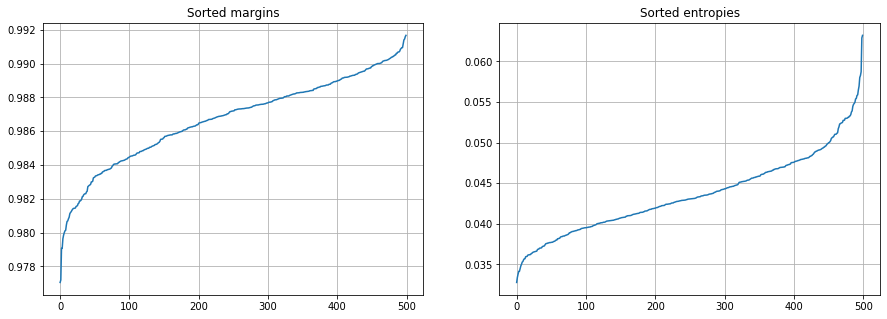

In [24]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title('Sorted margins')
plt.plot(np.sort(margins))
plt.grid()

plt.subplot(1,2,2)
plt.title('Sorted entropies')
plt.plot(np.sort(entropies))
plt.grid();

### Most confident examples

Min entropy: 0.033, Entropy: 0.033, Max entropy: 0.063
Min margin: 0.977, Margin: 0.992, Max margin: 0.992


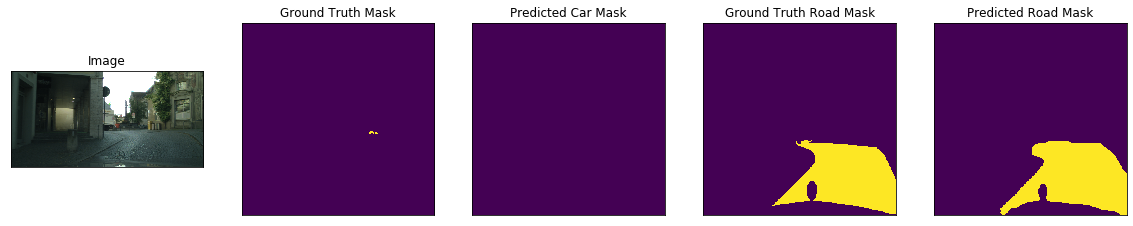

Min entropy: 0.033, Entropy: 0.034, Max entropy: 0.063
Min margin: 0.977, Margin: 0.992, Max margin: 0.992


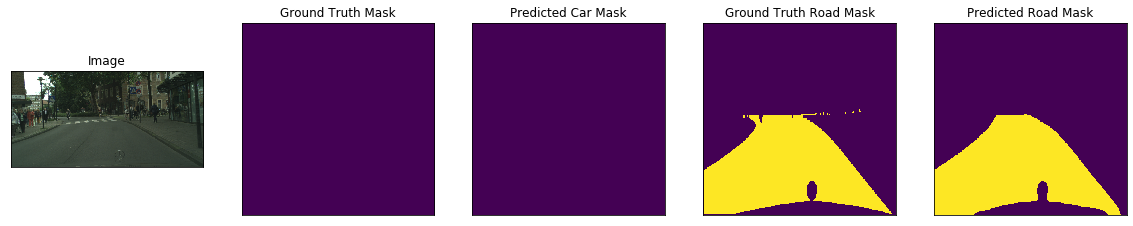

Min entropy: 0.033, Entropy: 0.034, Max entropy: 0.063
Min margin: 0.977, Margin: 0.991, Max margin: 0.992


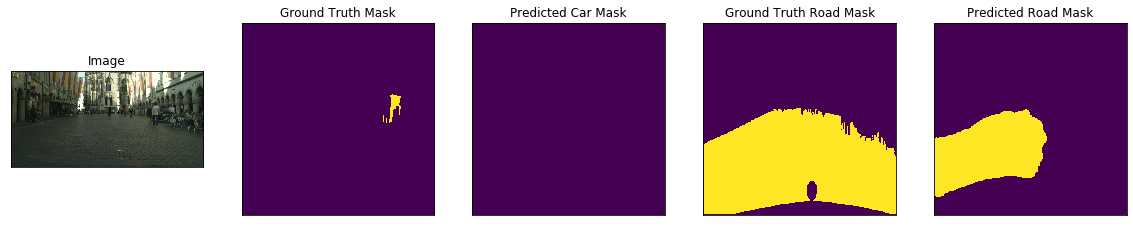

Min entropy: 0.033, Entropy: 0.034, Max entropy: 0.063
Min margin: 0.977, Margin: 0.991, Max margin: 0.992


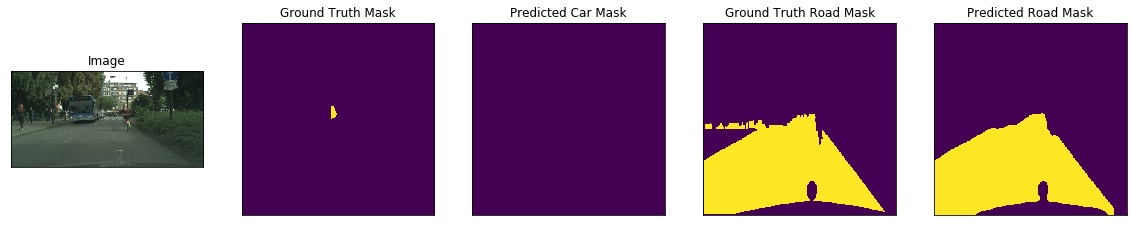

Min entropy: 0.033, Entropy: 0.036, Max entropy: 0.063
Min margin: 0.977, Margin: 0.991, Max margin: 0.992


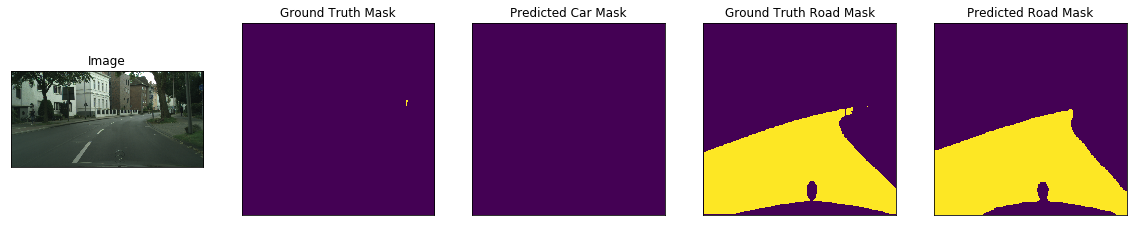

In [25]:
# Model is mostly uncertain in images with High entropy or Low margin
NUM_UNCERTAIN_IMAGES = 5
# selection = (np.argsort(entropies))[:NUM_UNCERTAIN_IMAGES]
selection = (np.argsort(margins))[::-1][:NUM_UNCERTAIN_IMAGES]

for i in selection:
    print(f'Min entropy: {np.min(entropies):.3f}, Entropy: {entropies[i]:.3f}, Max entropy: {np.max(entropies):.3f}')
    print(f'Min margin: {np.min(margins):.3f}, Margin: {margins[i]:.3f}, Max margin: {np.max(margins):.3f}')
    image, gt_mask = test_dataset[i]
    image_vis = test_dataset_vis[i][0].astype('uint8')
        
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    mask_np = pr_mask.squeeze().cpu().numpy().round()
    
    plt.figure(figsize=(20,10))
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask[1,...],
        predicted_car_mask=mask_np[1,...],
        ground_truth_road_mask=gt_mask[0,...],
        predicted_road_mask=mask_np[0,...],
    )
    plt.show()

### Most uncertain examples

Min entropy: 0.033, Entropy: 0.063, Max entropy: 0.063
Min margin: 0.977, Margin: 0.977, Max margin: 0.992


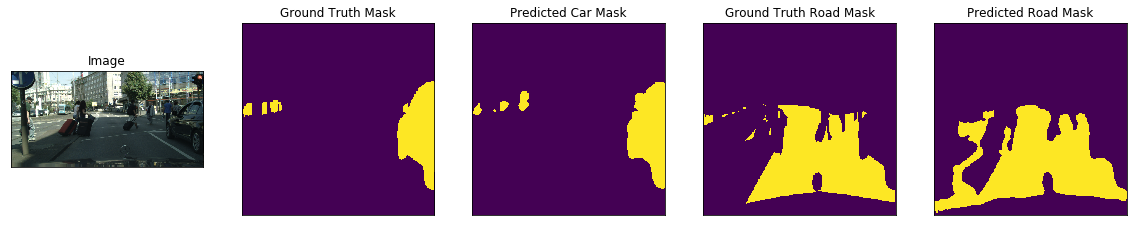

Min entropy: 0.033, Entropy: 0.063, Max entropy: 0.063
Min margin: 0.977, Margin: 0.977, Max margin: 0.992


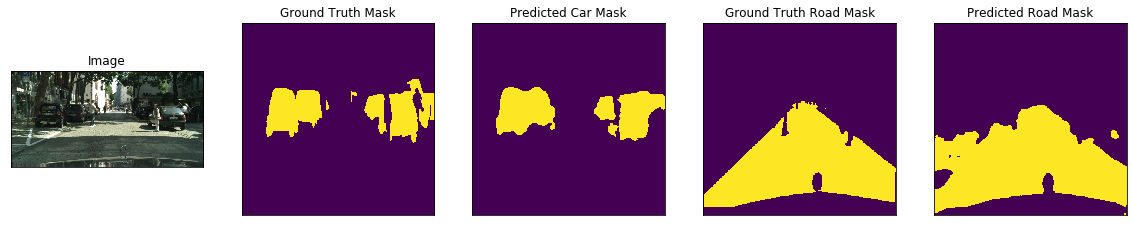

Min entropy: 0.033, Entropy: 0.058, Max entropy: 0.063
Min margin: 0.977, Margin: 0.979, Max margin: 0.992


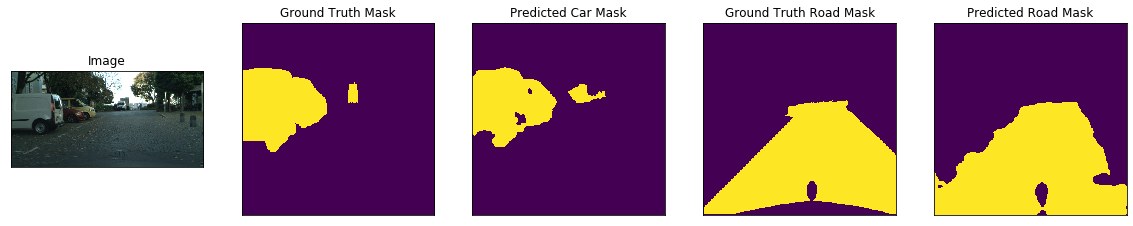

Min entropy: 0.033, Entropy: 0.059, Max entropy: 0.063
Min margin: 0.977, Margin: 0.979, Max margin: 0.992


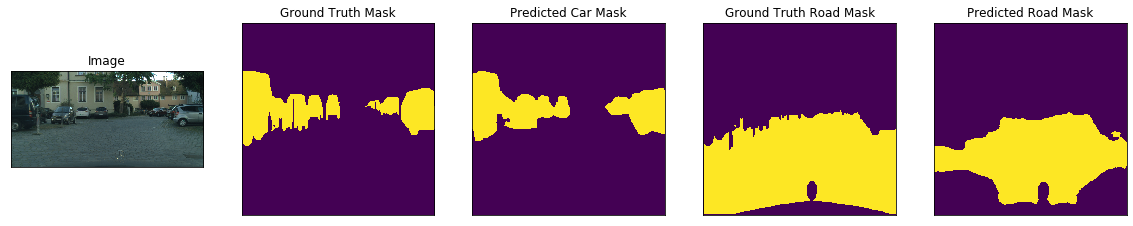

Min entropy: 0.033, Entropy: 0.056, Max entropy: 0.063
Min margin: 0.977, Margin: 0.980, Max margin: 0.992


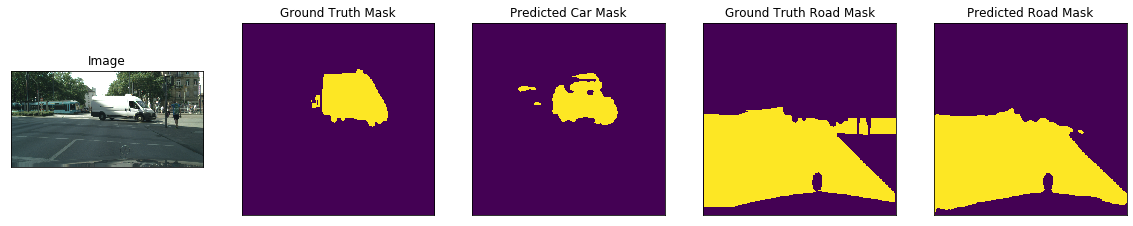

In [26]:
# Model is mostly uncertain in images with High entropy or Low margin
NUM_UNCERTAIN_IMAGES = 5
#selection = (np.argsort(entropies)[::-1])[:NUM_UNCERTAIN_IMAGES]
selection = np.argsort(margins)[:NUM_UNCERTAIN_IMAGES]

for i in selection:
    print(f'Min entropy: {np.min(entropies):.3f}, Entropy: {entropies[i]:.3f}, Max entropy: {np.max(entropies):.3f}')
    print(f'Min margin: {np.min(margins):.3f}, Margin: {margins[i]:.3f}, Max margin: {np.max(margins):.3f}')
    image, gt_mask = test_dataset[i]
    image_vis = test_dataset_vis[i][0].astype('uint8')
        
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    mask_np = pr_mask.squeeze().cpu().numpy().round()
    
    plt.figure(figsize=(20,10))
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask[1,...],
        predicted_car_mask=mask_np[1,...],
        ground_truth_road_mask=gt_mask[0,...],
        predicted_road_mask=mask_np[0,...],
    )
    plt.show()